# MoSDeF + HOOMD + Freud simulations of LJ particles at multiple thermodynamic states

We will be attempting to reproduce some RDFs produced by Moore et al. (2014). 
In this publication, LJ particles were simulated at a variety of thermodynamic statepoints.

![moore2014.png](./moore2014.png)

Moore, T. C.; Iacovella, C. R.; McCabe, C. Derivation of Coarse-Grained Potentials via Multistate Iterative Boltzmann Inversion. J. Chem. Phys. 2014, 140 (22).

In [1]:
import mbuild as mb
from mbuild.formats.hoomd3_forcefield import create_hoomd3_forcefield
from mbuild.formats.gsdwriter import write_gsd
import foyer
import unyt as u
import hoomd
%matplotlib inline
import matplotlib.pyplot as plt
import freud
import gsd

We will outline some basic constants to facilitate conversions to and from unitless to physical dimensions.
The foyer XML within this repo contains the same force field information.

In [2]:
# Basic constants and LJ Argon properties
sig = 0.34 * u.nm
eps = 1 * u.kilojoule
mass = 39.948 * u.amu
kb_per_mol = u.boltzmann_constant * 6.022e23
n = 2000

/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
!head -n15 ff.xml

<?xml version="1.0" encoding="UTF-8"?>
<ForceField >
  <!--XML units: kJ/mol for energies, nm for lengths, and radians for angles.-->
  <AtomTypes>
    <Type name="Ar" class="Ar" element="Ar" mass="39.948" def="[Ar]" desc="LJ Argon"/>
  </AtomTypes>
  <HarmonicBondForce>
  </HarmonicBondForce>
  <HarmonicAngleForce/>
  <RBTorsionForce>
  </RBTorsionForce>
  <NonbondedForce coulomb14scale="0.0" lj14scale="0.0">
    <Atom type="Ar" charge="0" sigma="0.34" epsilon="1.00"/>
  </NonbondedForce>
</ForceField>


/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# Define various thermodynamic state points, in reduced units
statepoints = {'a': {'T_r':0.5, 'rho_r':0.85},
                  'b': {'T_r':1.5, 'rho_r':0.67},
                  'c': {'T_r':2.0, 'rho_r':0.18}}

/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Iterate through each thermodynamic statepoint, building, parametrizing, and simulating the system
for i, statepoint in statepoints.items():
    # Create LJ particle
    lj_compound = mb.Compound(name='Ar')
    
    # Create mbuild Box based on reduced density
    volume = n * sig**3 / statepoint['rho_r'] 
    cubic_box_length = volume **(1/3)
    box = mb.Box([cubic_box_length, cubic_box_length, cubic_box_length])
    
    # Use mbuild to pack box with LJ particles
    # Use freud to wrap coordinates within box
    freud_box = freud.box.Box.from_box(box.lengths)
    filled_box = mb.fill_box(lj_compound, n_compounds=n, box=box)
    filled_box.xyz = freud_box.wrap(filled_box.xyz)
    
    # Apply foyer force field
    ff = foyer.Forcefield('ff.xml')
    structure = ff.apply(filled_box)
    
    # Dump initial coordinates
    write_gsd(structure, '{}_init.gsd'.format(i), ref_distance=10, ref_energy=1/4.184)

    # Create a snapshot and forcefield object
    snapshot, forcefield, ref_vals = create_hoomd3_forcefield(structure, ref_distance=10, ref_energy=1/4.184)
    
    # Define hoomd simulation
    device = hoomd.device.auto_select()
    simulation = hoomd.Simulation(device=device, seed=1)
    simulation.create_state_from_snapshot(snapshot)

    # Dump coordinates to GSD file
    gsd_writer = hoomd.write.GSD(filename='{}.gsd'.format(i),
                                 trigger=hoomd.trigger.Periodic(100),
                                 mode='wb')
    simulation.operations.writers.append(gsd_writer)
    
    # Enable MD integration with the forcefield from mbuild/foyer
    integrator = hoomd.md.Integrator(dt=0.005)
    integrator.forces = forcefield
        
    nvt = hoomd.md.methods.NVT(filter=hoomd.filter.All(),
                               kT = statepoint['T_r'],
                               tau=1.0)
    integrator.methods = [nvt]
    
    simulation.operations.integrator = integrator
    
    # Randomize initial velocitites
    simulation.state.thermalize_particle_momenta(filter=hoomd.filter.All(),
                                                 kT=statepoint['T_r'])    
    
    simulation.run(10000)


/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/foyer/forcefield.py:478: UserWarning: No force field version number found in force field XML file.
  warnings.warn(
/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/foyer/forcefield.py:490: UserWarning: No force field name found in force field XML file.
  warnings.warn(
/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/parmed/openmm/topsystem.py:240: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or 

Processing LJ and QQ


/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/parmed/openmm/topsystem.py:240: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  warnings.warn('Adding what seems to be Urey-Bradley terms before ' # pragma: no cover
*Warning*: nlist: No bonds defined while trying to add topology derived 1-3 exclusions


Processing LJ and QQ


/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/parmed/openmm/topsystem.py:240: OpenMMWarning: Adding what seems to be Urey-Bradley terms before Angles. This is unexpected, but the parameters will all be present in one form or another.
  warnings.warn('Adding what seems to be Urey-Bradley terms before ' # pragma: no cover
*Warning*: nlist: No bonds defined while trying to add topology derived 1-3 exclusions


Processing LJ and QQ


/scratch/joaander/miniforge3/envs/hoomd_lj/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


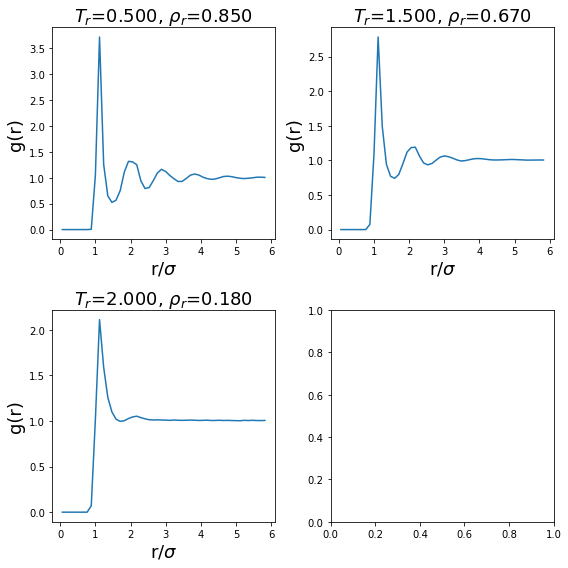

In [6]:
# Analyze the simulations by computing RDFs via freud
fig, ax = plt.subplots(2,2, figsize=(8,8))
for i, name in enumerate(statepoints):
    with gsd.hoomd.open('{}.gsd'.format(name), 'rb') as f:
        freud_rdf = freud.density.RDF(bins=50, r_max=2, r_min=0)
        for frame in f:
            freud_rdf.compute(system=frame, reset=False)
    row = i // 2
    col = i % 2
    
    density = statepoints[name]['rho_r']
    temperature = statepoints[name]['T_r']
    
    ax[row, col].set_ylabel("g(r)", size=18)
    ax[row, col].set_xlabel(r"r/$\sigma$", size=18)
    
    ax[row, col].set_title(r"$T_r$={:.3f}, $\rho_r$={:.3f}".format(temperature, density), size=18)
    ax[row, col].plot(freud_rdf.bin_centers/sig, freud_rdf.rdf)
    fig.tight_layout()


![moore2014.png](./moore2014.png)

Moore, T. C.; Iacovella, C. R.; McCabe, C. Derivation of Coarse-Grained Potentials via Multistate Iterative Boltzmann Inversion. J. Chem. Phys. 2014, 140 (22).